## HLS-VI testing notebook
This notebook compares the generated HLS-VI raster data with manually calculated indices.
Nine indices that are part of HLS-VI granule are NDVI, NDWI,NDMI, NBR, NBR2, TVI, EVI, SAVI, MSAVI

### Notes:
NDVI, NDWI,NDMI, NBR, NBR2, EVI, SAVI, MSAVI have a scaling factor of 10,000 but TVI has a scaling factor of 100.

To open the tif files, while many option exist, we are using `rasterio.open()` to be consistent with the `generate_indices.py` script. At the end of the notebook, a few other options to read the data is verified for a single pixel. But note that there can be subtle differences depending on the utility used for opening the rasters.


In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import rasterio

In [2]:
# define path to tif file
dir_path   = "/Users/sridhar22-mbp/Downloads/"

hls_granule_id = "HLS.S30.T14SMH.2024290T173321.v2.0"
vi_granule_id  = "HLS-VI.S30.T14SMH.2024290T173321.v2.0"

sat_id = hls_granule_id.split(".")[1]
print(sat_id)

S30


In [3]:
# Map Spectral Bands
# ignore Coastal aerosol and Cirrus bands
sr_bands_l30 = ['B02','B03','B04','B05','B06','B07', 'Fmask', '']
sr_bands_s30 = ['B02','B03','B04','B8A','B11','B12', 'Fmask', '']
common_bands = ["B","G","R","NIR","SWIR1", "SWIR2", 'Fmask']

sr_bands_common_l30 = dict(zip(sr_bands_l30, common_bands))
sr_bands_common_s30 = dict(zip(sr_bands_s30, common_bands))

print(sr_bands_common_l30)
print(sr_bands_common_s30)

{'B02': 'B', 'B03': 'G', 'B04': 'R', 'B05': 'NIR', 'B06': 'SWIR1', 'B07': 'SWIR2', 'Fmask': 'Fmask'}
{'B02': 'B', 'B03': 'G', 'B04': 'R', 'B8A': 'NIR', 'B11': 'SWIR1', 'B12': 'SWIR2', 'Fmask': 'Fmask'}


In [4]:
def open_file(base, band, band_name):
    ## Open raster and apply scale and offset
    fname = f"{base}.{band}.tif"
    print(f"Reading {fname}") 
    
    if band in ["Fmask"]:
        scale_factor = 1
    elif band in ["TVI"]:
        scale_factor = 100 ## TVI scale factor 
    else:
        scale_factor = 10_000
    
    try:
        #da = rxr.open_rasterio(fname, mask_and_scale=True)
        ## not using xarray here on purpose and keeping reading the tif using rasterio
        ## to keep it consistent with generate_indices.py
        with rasterio.open(fname) as tif:
            data = tif.read(1, masked=True, fill_value=-9999) / scale_factor
            
    except FileNotFoundError:
        print("There is no file ", fname)
    
    ## covert to xarray data array
    da = xr.DataArray(data)
    da.name = band_name
    return da

In [5]:
## Read HLS granule
sr_key = f"{dir_path}{hls_granule_id}/{hls_granule_id}" 

if sat_id == 'L30':
    print("Reading L30 raster data")
    sr_das = [open_file(sr_key, band, band_name) for (band,band_name) in zip(sr_bands_l30, common_bands)]
    sr_ds  = xr.merge(sr_das, combine_attrs="drop_conflicts") 
elif sat_id == 'S30':
    print("\nReading S30 raster data")
    sr_das = [open_file(sr_key, band, band_name) for (band,band_name) in zip(sr_bands_s30, common_bands)]
    sr_ds  = xr.merge(sr_das, combine_attrs="drop_conflicts")


Reading S30 raster data
Reading /Users/sridhar22-mbp/Downloads/HLS.S30.T14SMH.2024290T173321.v2.0/HLS.S30.T14SMH.2024290T173321.v2.0.B02.tif
Reading /Users/sridhar22-mbp/Downloads/HLS.S30.T14SMH.2024290T173321.v2.0/HLS.S30.T14SMH.2024290T173321.v2.0.B03.tif
Reading /Users/sridhar22-mbp/Downloads/HLS.S30.T14SMH.2024290T173321.v2.0/HLS.S30.T14SMH.2024290T173321.v2.0.B04.tif
Reading /Users/sridhar22-mbp/Downloads/HLS.S30.T14SMH.2024290T173321.v2.0/HLS.S30.T14SMH.2024290T173321.v2.0.B8A.tif
Reading /Users/sridhar22-mbp/Downloads/HLS.S30.T14SMH.2024290T173321.v2.0/HLS.S30.T14SMH.2024290T173321.v2.0.B11.tif
Reading /Users/sridhar22-mbp/Downloads/HLS.S30.T14SMH.2024290T173321.v2.0/HLS.S30.T14SMH.2024290T173321.v2.0.B12.tif
Reading /Users/sridhar22-mbp/Downloads/HLS.S30.T14SMH.2024290T173321.v2.0/HLS.S30.T14SMH.2024290T173321.v2.0.Fmask.tif


In [6]:
red   = sr_ds["R"].round(4)
blue  = sr_ds["B"].round(4)
green = sr_ds["G"].round(4)
nir   = sr_ds["NIR"].round(4)
swir1 = sr_ds["SWIR1"].round(4)
swir2 = sr_ds["SWIR2"].round(4)
fmask = sr_ds["Fmask"].round(4)

In [7]:
## NOTE: to get matching results, num_dec must be 2 for TVI
## number of decimal places to round

num_dec = 4     
num_dec_tvi = 2 ## use fewer decimal places for TVI

def calc_ndvi(red, nir):
    NDVI_calc = (nir - red)/(nir + red)
    return np.round(NDVI_calc,num_dec)

def calc_ndwi(green, nir):
    NDWI_calc = (green - nir)/(green + nir)
    return np.round(NDWI_calc,num_dec)

def calc_ndmi(swir1, nir):
    NDMI_calc = (nir - swir1)/(nir + swir1)
    return np.round(NDMI_calc,num_dec)

def calc_nbr(swir2, nir):
    NBR_calc  = (nir - swir2)/(nir + swir2)
    return np.round(NBR_calc,num_dec)

def calc_nbr2(swir2, swir1):
    NBR2_calc = (swir1 - swir2)/(swir1 + swir2)
    return np.round(NBR2_calc,num_dec)
    
def calc_evi(nir, red, blue):
    EVI_calc  = 2.5*(nir  - red)/ (nir + 6*red -7.5*blue +1)
    return np.round(EVI_calc,num_dec)
 
def calc_msavi(nir, red):
    MSAVI_calc= (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
    return np.round(MSAVI_calc,num_dec)

def calc_tvi(nir, green):
    TVI_calc  = (120*(nir - green) - 200*(red - green ))/2
    return np.round(TVI_calc,num_dec_tvi)

def calc_savi(nir, red):   
    SAVI_calc = 1.5*(nir - red) / (nir + red + 0.5)
    return np.round(SAVI_calc,num_dec)


NDVI_calc = calc_ndvi(red, nir)
NDWI_calc = calc_ndwi(green, nir)
NDMI_calc = calc_ndmi(swir1, nir)
NBR_calc  = calc_nbr(swir2, nir)
NBR2_calc = calc_nbr2(swir2, swir1)
EVI_calc  = calc_evi(nir, red, blue)
MSAVI_calc= calc_msavi(nir, red)
TVI_calc  = calc_tvi(nir, green)
SAVI_calc = calc_savi(nir, red)

In [8]:
# Read VI granule
sr_bands_vi = ['NDVI','NDWI','NDMI','NBR','NBR2','EVI', 'MSAVI', 'TVI', 'SAVI']
sr_key_vi = f"{dir_path}/{vi_granule_id}/{vi_granule_id}" 

print(f"Reading VI raster data")
sr_das_vi = [open_file(sr_key_vi, band, band) for (band) in sr_bands_vi]
sr_ds_vi  = xr.merge(sr_das_vi, combine_attrs="drop_conflicts") 

Reading VI raster data
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290T173321.v2.0.NDVI.tif
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290T173321.v2.0.NDWI.tif
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290T173321.v2.0.NDMI.tif
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290T173321.v2.0.NBR.tif
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290T173321.v2.0.NBR2.tif
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290T173321.v2.0.EVI.tif
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290T173321.v2.0.MSAVI.tif
Reading /Users/sridhar22-mbp/Downloads//HLS-VI.S30.T14SMH.2024290T173321.v2.0/HLS-VI.S30.T14SMH.2024290

In [9]:
## Round dataarrays to 4 decimal places
NDVI_ref = sr_ds_vi["NDVI"].round(decimals = 4)
NDWI_ref = sr_ds_vi["NDWI"].round(decimals = 4)
NDMI_ref = sr_ds_vi["NDMI"].round(decimals = 4)
NBR_ref  = sr_ds_vi["NBR"].round(decimals = 4)
NBR2_ref = sr_ds_vi["NBR2"].round(decimals = 4)
EVI_ref  = sr_ds_vi["EVI"].round(decimals = 4)
MSAVI_ref= sr_ds_vi["MSAVI"].round(decimals = 4)
TVI_ref  = sr_ds_vi["TVI"].round(decimals = 4)
SAVI_ref = sr_ds_vi["SAVI"].round(decimals = 4)

In [10]:
def calc_per_diff(calc_data, ref_data):
    ### Percentage difference 
    return 100*(ref_data - calc_data) / ref_data

In [11]:
## consider only the clean pixels filtered using Fmask layer
clean_bits = {64, 128}
fmask_array = sr_ds[['Fmask']].squeeze().to_array()

# Create the clean mask
clean_mask = fmask_array.isin(list(clean_bits))

def get_clean_data(data, mask):
    masked_raster = data.where(clean_mask==True)
    return masked_raster

masked_raster_ndvi_calc = get_clean_data(NDVI_calc, clean_mask)
masked_raster_ndwi_calc = get_clean_data(NDWI_calc, clean_mask)
masked_raster_ndmi_calc = get_clean_data(NDMI_calc, clean_mask)
masked_raster_nbr_calc  = get_clean_data(NBR_calc, clean_mask)
masked_raster_nbr2_calc = get_clean_data(NBR2_calc, clean_mask)
masked_raster_evi_calc  = get_clean_data(EVI_calc, clean_mask)
masked_raster_msavi_calc= get_clean_data(MSAVI_calc, clean_mask)
masked_raster_tvi_calc  = get_clean_data(TVI_calc, clean_mask)
masked_raster_savi_calc = get_clean_data(SAVI_calc, clean_mask)

masked_raster_ndvi_ref = sr_das_vi[0].where(clean_mask==True)
masked_raster_ndwi_ref = sr_das_vi[1].where(clean_mask==True)
masked_raster_ndmi_ref = sr_das_vi[2].where(clean_mask==True)
masked_raster_nbr_ref  = sr_das_vi[3].where(clean_mask==True)
masked_raster_nbr2_ref = sr_das_vi[4].where(clean_mask==True)
masked_raster_evi_ref  = sr_das_vi[5].where(clean_mask==True)
masked_raster_msavi_ref= sr_das_vi[6].where(clean_mask==True)
masked_raster_tvi_ref  = sr_das_vi[7].where(clean_mask==True)
masked_raster_savi_ref = sr_das_vi[8].where(clean_mask==True)

In [12]:
#percent diff for masked raster
ndvi_perdiff = calc_per_diff(masked_raster_ndvi_calc, masked_raster_ndvi_ref)
ndwi_perdiff = calc_per_diff(masked_raster_ndwi_calc, masked_raster_ndwi_ref)
ndmi_perdiff = calc_per_diff(masked_raster_ndmi_calc, masked_raster_ndmi_ref)
nbr_perdiff = calc_per_diff(masked_raster_nbr_calc, masked_raster_nbr_ref)
nbr2_perdiff = calc_per_diff(masked_raster_nbr2_calc, masked_raster_nbr2_ref)
evi_perdiff = calc_per_diff(masked_raster_evi_calc, masked_raster_evi_ref)
msavi_perdiff = calc_per_diff(masked_raster_msavi_calc, masked_raster_msavi_ref)
tvi_perdiff = calc_per_diff(masked_raster_tvi_calc, masked_raster_tvi_ref)
savi_perdiff = calc_per_diff(masked_raster_savi_calc, masked_raster_savi_ref)

In [19]:
#Define threshold to check for differences
t = 0.1 # percent

def print_differences(calc, ref, perdiff, t, index):
    # get pixels with +/- t % difference
    calc_bad    = calc.where((perdiff>t) | (perdiff<-t)).values.ravel()
    calc_notnan = calc_bad[~np.isnan(calc_bad)]

    ref_bad    = ref.where((perdiff>t) | (perdiff<-t)).values.ravel()
    ref_notnan = ref_bad[~np.isnan(ref_bad)]
    
    allclose = np.allclose(calc_notnan, ref_notnan) ## default tolerance
    diff = np.subtract(calc_notnan, ref_notnan)
    diff_idx = np.argsort(diff)

    
    print(f"{index} Top five pixels with difference of +/- {t}%")
    print(f"Calc: {calc_notnan[diff_idx][-5:]}") # print 5 worse pixel values 
    print(f"Raster: {ref_notnan[diff_idx][-5:]}") # print 5 worse pixel values 
    print(f"Diff: {diff[diff_idx][-5:]}")
    print(f"Num of pixels with Diff: {len(diff)}")
    print(f"Allclose: {allclose}")
    print()
    
print_differences(masked_raster_ndvi_calc, masked_raster_ndvi_ref, ndvi_perdiff, t, "NDVI") 
print_differences(masked_raster_ndwi_calc, masked_raster_ndwi_ref, ndwi_perdiff, t, "NDWI") 
print_differences(masked_raster_ndmi_calc, masked_raster_ndmi_ref, ndmi_perdiff, t, "NDMI") 
print_differences(masked_raster_tvi_calc, masked_raster_tvi_ref, tvi_perdiff, t, "TVI") 
print_differences(masked_raster_nbr_calc, masked_raster_nbr_ref, nbr_perdiff, t, "NBR") 
print_differences(masked_raster_nbr2_calc, masked_raster_nbr2_ref, nbr2_perdiff, t, "NBR2") 
print_differences(masked_raster_savi_calc, masked_raster_savi_ref, savi_perdiff, t, "SAVI") 
print_differences(masked_raster_msavi_calc, masked_raster_msavi_ref, msavi_perdiff, t, "MSAVI")

NDVI Top five pixels with difference of +/- 0.1%
Calc: []
Raster: []
Diff: []
Num of pixels with Diff: 0
Allclose: True

NDWI Top five pixels with difference of +/- 0.1%
Calc: []
Raster: []
Diff: []
Num of pixels with Diff: 0
Allclose: True

NDMI Top five pixels with difference of +/- 0.1%
Calc: [-0.0563 -0.0563 -0.0563]
Raster: [-0.0562 -0.0562 -0.0562]
Diff: [-0.0001 -0.0001 -0.0001]
Num of pixels with Diff: 3
Allclose: False

TVI Top five pixels with difference of +/- 0.1%
Calc: []
Raster: []
Diff: []
Num of pixels with Diff: 0
Allclose: True

NBR Top five pixels with difference of +/- 0.1%
Calc: [0.0438 0.0563 0.0563 0.0563 0.0563]
Raster: [0.0437 0.0562 0.0562 0.0562 0.0562]
Diff: [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
Num of pixels with Diff: 7
Allclose: False

NBR2 Top five pixels with difference of +/- 0.1%
Calc: [0.0693 0.0568 0.0863 0.0863]
Raster: [0.0692 0.0567 0.0862 0.0862]
Diff: [0.0001 0.0001 0.0001 0.0001]
Num of pixels with Diff: 4
Allclose: False

SAVI Top five pixels 

/var/folders/nb/zbf9tcqj0194rts9b7nc7sqm0000gp/T/ipykernel_32307/1656304672.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20b', 2))
/var/folders/nb/zbf9tcqj0194rts9b7nc7sqm0000gp/T/ipykernel_32307/1656304672.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20b', 20))


 NDVI %DIFF Max: 0.0, Min: -0.04625346901017067
 NDWI %DIFF Max: -0.0, Min: -0.0316255534471994
 NDMI %DIFF Max: -0.0, Min: -0.1779359430605033
 NBR %DIFF Max: 0.0, Min: -0.22883295194507075
 NBR2 %DIFF Max: 0.0, Min: -0.17636684303351474
 EVI %DIFF Max: 0.0, Min: -0.07082152974505436
 msavi %DIFF Max: 0.0, Min: 0.0
 tvi %DIFF Max: 0.0, Min: 0.0
 SAVI %DIFF Max: 0.0, Min: -0.09328358208955491


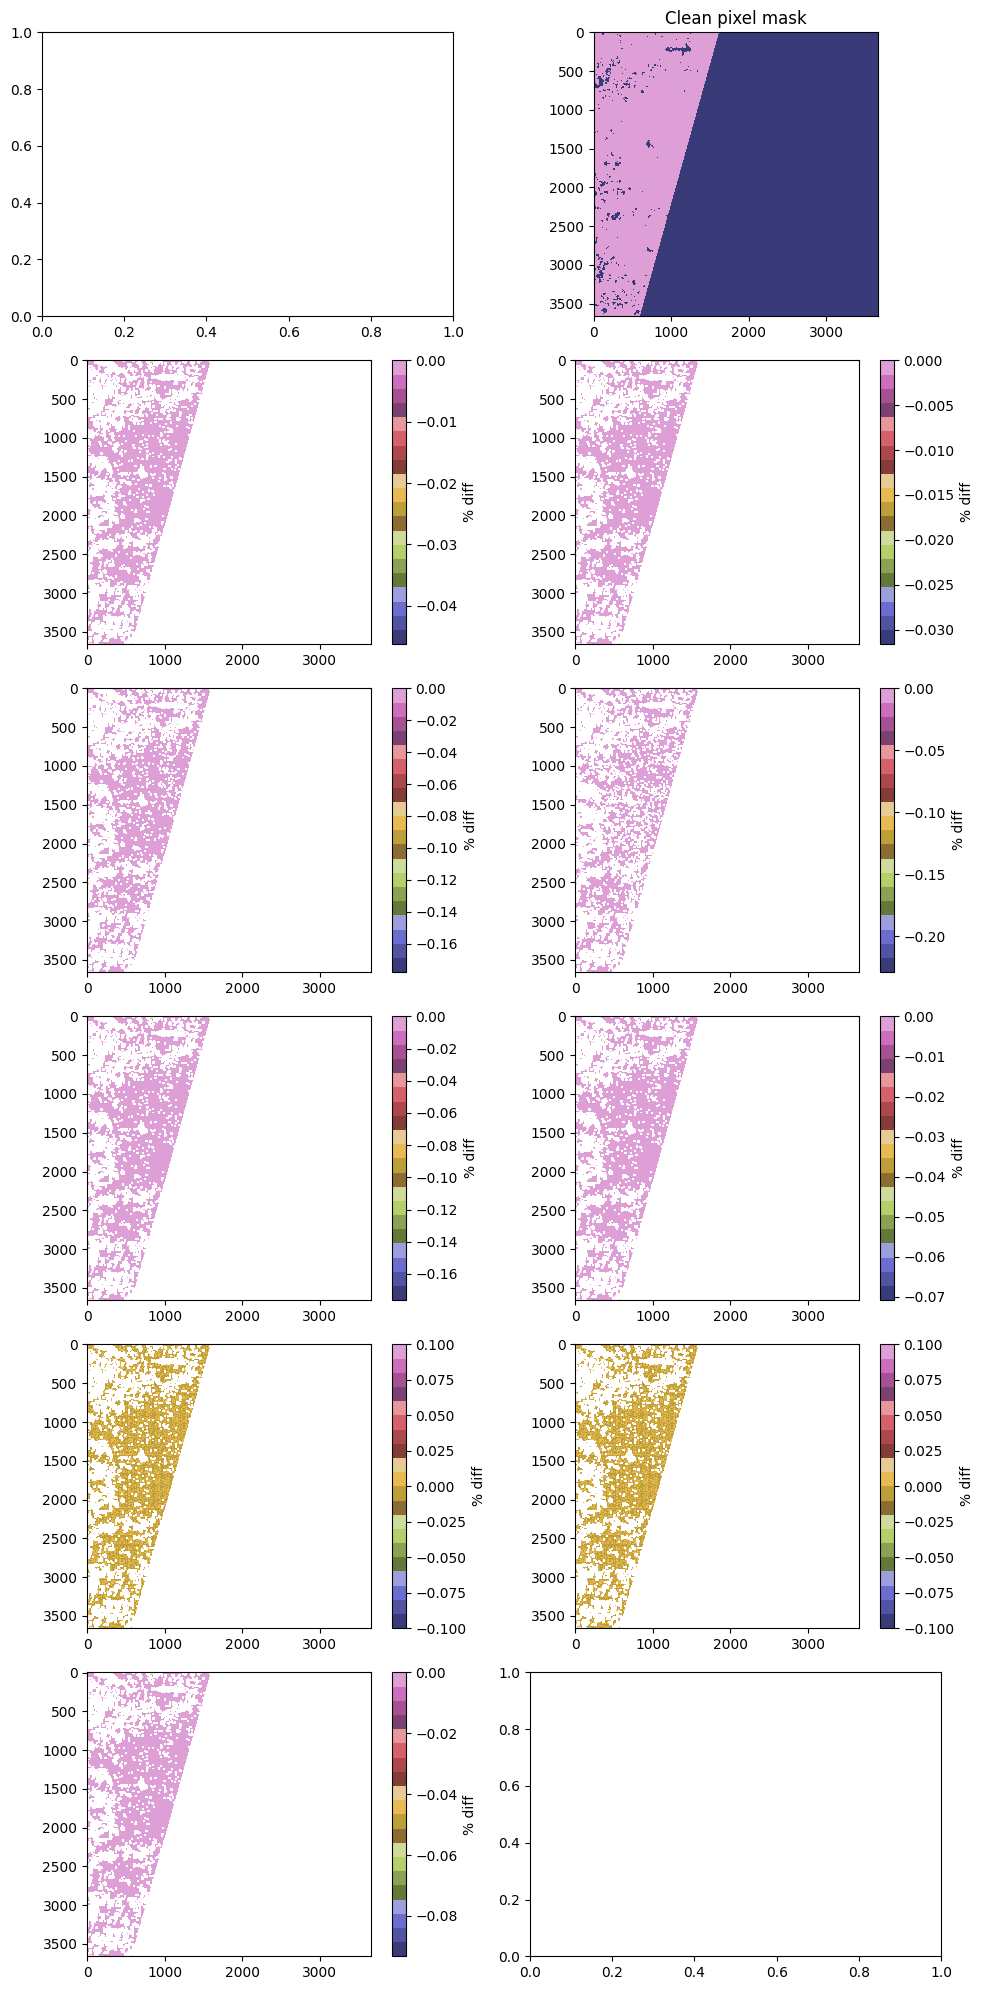

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6,2, figsize=(10, 20))

def plot_raster(data, fig, ax, title):
    im = ax.imshow(data.squeeze(),
               cmap=plt.cm.get_cmap('tab20b', 20))
    fig.colorbar(im, label='% diff')
    print(f" {title} Max: {np.nanmax(data)}, Min: {np.nanmin(data)}")

# RGB
# sr_ds[['R','G','B']].squeeze().to_array().plot.imshow(ax=ax[0,0], robust=True)

# Clean pixel mask
im1 = ax[0,1].imshow(clean_mask.squeeze(),
               cmap=plt.cm.get_cmap('tab20b', 2))
ax[0,1].set_title("Clean pixel mask")

plot_raster(ndvi_perdiff, fig, ax[1,0], "NDVI %DIFF")
plot_raster(ndwi_perdiff, fig, ax[1,1], "NDWI %DIFF")
plot_raster(ndmi_perdiff, fig, ax[2,0], "NDMI %DIFF")
plot_raster(nbr_perdiff, fig, ax[2,1], "NBR %DIFF")
plot_raster(nbr2_perdiff, fig, ax[3,0], "NBR2 %DIFF")
plot_raster(evi_perdiff, fig, ax[3,1], "EVI %DIFF")
plot_raster(msavi_perdiff, fig, ax[4,0], "msavi %DIFF")
plot_raster(tvi_perdiff, fig, ax[4,1], "tvi %DIFF")
plot_raster(savi_perdiff, fig, ax[5,0], "SAVI %DIFF")

fig.tight_layout()

## Check reading data with a few readers

In [21]:
ndvi_tif = f"{sr_key_vi}.NDVI.tif"
xidx = 3000
yidx = 100

In [16]:
# using rasterio
data = rasterio.open(ndvi_tif)
print(data.read(1)[xidx, yidx])

2075


In [17]:
# Using xarray
import xarray
data = xarray.open_dataset(ndvi_tif, mask_and_scale=False)
print(data.to_array().squeeze()[xidx, yidx].values)

2075


In [18]:
# Using rioxarray
import rioxarray
data = rioxarray.open_rasterio(ndvi_tif)
print(data.values[0][xidx, yidx])

2075
